# Implementation of PPO based on:
https://www.datacamp.com/tutorial/proximal-policy-optimization

Trust-region-based methods aim to avoid this problem by ensuring policy updates are within a trusted region. This trusted region is an artificially constrained region within the policy space within which updates are allowed. The updated policy can only be within a trusted region of the old policy. Ensuring that policy updates are incremental prevents instability.

The Trust Region Policy Updates (TRPO) algorithm was proposed in 2015 by John Schulman (who also proposed PPO in 2017). To measure the difference between the old policy and the updated policy, TRPO uses Kullback-Leibler (KL) divergence. KL divergence is used to measure the difference between two probability distributions. TRPO proved to be effective at implementing trust regions.

The problem with TRPO is the computational complexity associated with KL divergence. Applying KL divergence has to be expanded to the second order using numerical methods like Taylor expansion. This is computationally expensive. PPO was proposed as a simpler and more efficient alternative to TRPO. PPO clips the ratio of the policies to approximate the trust region without resorting to complex calculations involving KL divergence.

The clipped objective function is the main innovation in PPO. It prevents large policy updates in a single training iteration. It limits how much the policy is updated in a single iteration. To measure incremental policy updates, policy-based methods use the probability ratio of the new policy to the old policy.
The surrogate loss is the objective function in PPO and it takes into account the innovations mentioned earlier. It is computed as follows:
Compute the actual ratio (as explained earlier) and multiply it with the advantage.
Clip the ratio to lie within a desired range. Multiply the clipped ratio to the advantage.
Take the minimum value of the above two quantities.
In practice, an entropy term is also added to the surrogate loss. This is called the entropy bonus. It is based on the mathematical distribution of action probabilities. The idea behind the entropy bonus is to introduce some additional randomness in a controlled fashion. Doing this encourages the optimization process to explore the action space. A high entropy bonus promotes exploration over exploitation.

Suppose that under the old policy πold, the probability of taking action a in state s is πold(a|s). Under the new policy, the probability of taking the same action a from the same state s is updated to πnew(a|s). The ratio of these probabilities, as a function of the policy parameters θ, is r(θ). When the new policy makes the action more probable (in the same state), the ratio is greater than 1 and vice versa.

The clipping mechanism restricts this probability ratio such that the new action probabilities must lie within a certain percentage of the old action probabilities. For example, r(θ) can be constrained to lie between 0.8 and 1.2. This prevents large jumps, which in turn ensures a stable training process.

In [14]:
!pip install torch numpy matplotlib gym==0.25.2

import gym
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.distributions as distributions
import numpy as np
import matplotlib.pyplot as plt

## Defining the policy network
As explained earlier, PPO is implemented as an actor-critic model. The actor implements the policy, and the critic predicts its estimated value. Both actor and critic neural networks take the same input—the state at each timestep. Thus, the actor and critic models can share a common neural network, which is referred to as the backbone architecture. The actor and critic can extend the backbone architecture with additional layers.

In [ ]:

env_train = gym.make('CartPole-v1')
env_test = gym.make('CartPole-v1')

class BackboneNetwork(nn.Module):
    def __init__(self, in_features, hidden_dimensions, out_features, dropout):
        super().__init__()
        self.layer1 = nn.Linear(in_features, hidden_dimensions)
        self.layer2 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.layer3 = nn.Linear(hidden_dimensions, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer1(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = f.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x

class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic

    def forward(self, state):
        # DICA: Combine o forward da rede ator e da rede crítica.
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred

In [16]:
def create_agent(hidden_dimensions, dropout):
    INPUT_FEATURES = env_train.observation_space.shape[0]
    HIDDEN_DIMENSIONS = hidden_dimensions
    ACTOR_OUTPUT_FEATURES = env_train.action_space.n
    CRITIC_OUTPUT_FEATURES = 1
    DROPOUT = dropout

    # DICA: Use a classe BackboneNetwork para criar as redes.
    actor = BackboneNetwork(INPUT_FEATURES, HIDDEN_DIMENSIONS, ACTOR_OUTPUT_FEATURES, DROPOUT)
    critic = BackboneNetwork(INPUT_FEATURES, HIDDEN_DIMENSIONS, CRITIC_OUTPUT_FEATURES, DROPOUT)
    agent = ActorCritic(actor,critic)
    return agent


In [17]:
def calculate_returns(rewards, discount_factor):
    # DICA: Use a equação G_t = R_t + γ * G_{t+1} de forma reversa.
    returns = []
    cumulative_reward = 0
    for r in reversed(rewards):
        cumulative_reward = r + cumulative_reward * discount_factor
        returns.insert(0, cumulative_reward)
    returns = torch.tensor(returns)
    # normalize the return
    returns = (returns - returns.mean()) / returns.std()
    return returns



In [18]:
def calculate_advantages(returns, values):
    # DICA: Subtraia os valores estimados (critic) dos retornos reais acumulados.
    advantages = returns - values
    # Normalize the advantage
    advantages = (advantages - advantages.mean()) / advantages.std()
    return advantages

## Surrogate loss and clipping mechanism
The policy loss would be the standard policy gradient loss without special techniques like PPO. The standard policy gradient loss is calculated as the product of:

The policy action probabilities
The advantage function, which is calculated as the difference between:
The policy return
The expected value
The standard policy gradient loss cannot make corrections for abrupt policy changes. The surrogate loss modifies the standard loss to restrict the amount the policy can change in each iteration. It is the minimum of two quantities:

The product of:
The policy ratio. This ratio expresses the difference between the old and new action probabilities.  
The advantage function
The product of:
The clamped value of the policy ratio. This ratio is clipped such that the updated policy is within a certain percentage of the old policy.
The advantage function
For the optimization process, the surrogate loss is used as a proxy for the actual loss.

### The clipping mechanism
The policy ratio, R, is the difference between the new and old policies and is given as the ratio of the log probabilities of the policy under the new and old parameters:



The clipped policy ratio, R', is constrained such that:



Given the advantage, At, as shown in the previous section, and the policy ratio, as shown above, the surrogate loss is calculated as:



In [19]:
def calculate_surrogate_loss(
        actions_log_probability_old,
        actions_log_probability_new,
        epsilon,
        advantages):
    advantages = advantages.detach()
    policy_ratio = (
            actions_log_probability_new - actions_log_probability_old
            ).exp()
    surrogate_loss_1 = policy_ratio * advantages
    surrogate_loss_2 = torch.clamp(
            policy_ratio, min=1.0-epsilon, max=1.0+epsilon
            ) * advantages
    surrogate_loss = torch.min(surrogate_loss_1, surrogate_loss_2)
    return surrogate_loss

## Calculating policy and value loss
We are now ready to calculate the policy and value losses:

The policy loss is the sum of the surrogate loss and the entropy bonus.
The value loss is based on the difference between the value predicted by the critic and the returns (cumulative reward) generated by the policy. The value loss computation uses the Smooth L1 Loss function. This helps to smoothen the loss function and makes it less sensitive to outliers.
Both the losses, as computed above, are tensors. Gradient descent is based on scalar values. To get a single scalar value representing the loss, use the .sum() function to sum the tensor elements. The function below shows how to do this:

In [20]:
def calculate_losses(
        surrogate_loss, entropy, entropy_coefficient, returns, value_pred):
    entropy_bonus = entropy_coefficient * entropy
    policy_loss = -(surrogate_loss + entropy_bonus).sum()
    value_loss = f.smooth_l1_loss(returns, value_pred).sum()
    return policy_loss, value_loss

In [21]:
def init_training():
    states = []
    actions = []
    actions_log_probability = []
    values = []
    rewards = []
    done = False
    episode_reward = 0
    return states, actions, actions_log_probability, values, rewards, done, episode_reward

In the forward pass we are going to take a single episode

In [22]:
def forward_pass(env, agent, optimizer, discount_factor):
    states, actions, actions_log_probability, values, rewards, done, episode_reward = init_training()
    state = env.reset()
    agent.train()
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        states.append(state)
        action_pred, value_pred = agent(state)
        action_prob = f.softmax(action_pred, dim=-1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        state, reward, done, _ = env.step(action.item())
        actions.append(action)
        actions_log_probability.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        episode_reward += reward
    states = torch.cat(states)
    actions = torch.cat(actions)
    actions_log_probability = torch.cat(actions_log_probability)
    values = torch.cat(values).squeeze(-1)
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    return episode_reward, states, actions, actions_log_probability, advantages, returns

Each training iteration runs the model through a complete episode consisting of many timesteps (until it reaches a terminal condition). In each timestep, we store the policy parameters, the agent’s action, the returns, and the advantages. After each iteration, we update the model based on the policy’s performance through all the timesteps in that iteration.

The maximum number of timesteps in the CartPole environment is 500. In more complex environments, there are more timesteps, even millions. In such cases, the training results dataset must be split into batches. The number of timesteps in each batch is called the optimization batch size.

Thus, the steps to update the model parameters are:

Split the training results dataset into batches.
For each batch:
Get the agent’s action and the predicted value for each state.
Use these predicted actions to estimate the new action probability distribution.
Use this distribution to calculate the entropy.
Use this distribution to get the log probability of the actions in the training results dataset. This is the new set of log probabilities of the actions in the training results dataset. The old set of log probabilities of these same actions was calculated in the training loop explained in the previous section.
Calculate the surrogate loss using the actions' old and new probability distributions.
Calculate the policy loss and the value loss using the surrogate loss, the entropy, and the advantages.
Run .backward() separately on the policy and value losses. This updates the gradients on the loss functions.
Run .step() on the optimizer to update the policy parameters. In this case, we use the Adam optimizer to balance speed and robustness.
Accumulate the policy and value losses.
Repeat the backward pass (the above operations) on each batch a few times, depending on the value of the parameter PPO_STEPS. Repeating the backward pass on each batch is computationally efficient because it effectively increases the size of the training dataset without having to run additional forward passes. The number of environment steps in each alternation between sampling and optimization is called the iteration batch size.
Return the average policy loss and value loss.

In [23]:
def update_policy(
        agent,
        states,
        actions,
        actions_log_probability_old,
        advantages,
        returns,
        optimizer,
        ppo_steps,
        epsilon,
        entropy_coefficient):
    BATCH_SIZE = 128
    total_policy_loss = 0
    total_value_loss = 0
    actions_log_probability_old = actions_log_probability_old.detach()
    actions = actions.detach()
    training_results_dataset = TensorDataset(
            states,
            actions,
            actions_log_probability_old,
            advantages,
            returns)
    batch_dataset = DataLoader(
            training_results_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False)
    for _ in range(ppo_steps):
        for batch_idx, (states, actions, actions_log_probability_old, advantages, returns) in enumerate(batch_dataset):
            # get new log prob of actions for all input states
            action_pred, value_pred = agent(states)
            value_pred = value_pred.squeeze(-1)
            action_prob = f.softmax(action_pred, dim=-1)
            probability_distribution_new = distributions.Categorical(
                    action_prob)
            entropy = probability_distribution_new.entropy()
            # estimate new log probabilities using old actions
            actions_log_probability_new = probability_distribution_new.log_prob(actions)
            surrogate_loss = calculate_surrogate_loss(
                    actions_log_probability_old,
                    actions_log_probability_new,
                    epsilon,
                    advantages)
            policy_loss, value_loss = calculate_losses(
                    surrogate_loss,
                    entropy,
                    entropy_coefficient,
                    returns,
                    value_pred)
            optimizer.zero_grad()
            policy_loss.backward()
            value_loss.backward()
            optimizer.step()
            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [24]:
def evaluate(env, agent):
    agent.eval()
    rewards = []
    done = False
    episode_reward = 0
    state = env.reset()
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_pred, _ = agent(state)
            action_prob = f.softmax(action_pred, dim=-1)
        action = torch.argmax(action_prob, dim=-1)
        state, reward, done, _ = env.step(action.item())
        episode_reward += reward
    return episode_reward

In [25]:
def plot_train_rewards(train_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(train_rewards, label='Training Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Training Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(train_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [26]:
def plot_test_rewards(test_rewards, reward_threshold):
    plt.figure(figsize=(12, 8))
    plt.plot(test_rewards, label='Testing Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Testing Reward', fontsize=20)
    plt.hlines(reward_threshold, 0, len(test_rewards), color='y')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [27]:
def plot_losses(policy_losses, value_losses):
    plt.figure(figsize=(12, 8))
    plt.plot(value_losses, label='Value Losses')
    plt.plot(policy_losses, label='Policy Losses')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [28]:
def run_ppo():
    MAX_EPISODES = 500
    DISCOUNT_FACTOR = 0.99
    REWARD_THRESHOLD = 475
    PRINT_INTERVAL = 10
    PPO_STEPS = 8
    N_TRIALS = 100
    EPSILON = 0.2
    ENTROPY_COEFFICIENT = 0.01
    HIDDEN_DIMENSIONS = 64
    DROPOUT = 0.2
    LEARNING_RATE = 0.001
    train_rewards = []
    test_rewards = []
    policy_losses = []
    value_losses = []
    agent = create_agent(HIDDEN_DIMENSIONS, DROPOUT)
    optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE)
    for episode in range(1, MAX_EPISODES+1):
        train_reward, states, actions, actions_log_probability, advantages, returns = forward_pass(
                env_train,
                agent,
                optimizer,
                DISCOUNT_FACTOR)
        policy_loss, value_loss = update_policy(
                agent,
                states,
                actions,
                actions_log_probability,
                advantages,
                returns,
                optimizer,
                PPO_STEPS,
                EPSILON,
                ENTROPY_COEFFICIENT)
        test_reward = evaluate(env_test, agent)
        policy_losses.append(policy_loss)
        value_losses.append(value_loss)
        train_rewards.append(train_reward)
        test_rewards.append(test_reward)
        mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
        mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
        mean_abs_policy_loss = np.mean(np.abs(policy_losses[-N_TRIALS:]))
        mean_abs_value_loss = np.mean(np.abs(value_losses[-N_TRIALS:]))
        if episode % PRINT_INTERVAL == 0:
            print(f'Episode: {episode:3} | \
                  Mean Train Rewards: {mean_train_rewards:3.1f} \
                  | Mean Test Rewards: {mean_test_rewards:3.1f} \
                  | Mean Abs Policy Loss: {mean_abs_policy_loss:2.2f} \
                  | Mean Abs Value Loss: {mean_abs_value_loss:2.2f}')
        if mean_test_rewards >= REWARD_THRESHOLD:
            print(f'Reached reward threshold in {episode} episodes')
            break
    plot_train_rewards(train_rewards, REWARD_THRESHOLD)
    plot_test_rewards(test_rewards, REWARD_THRESHOLD)
    plot_losses(policy_losses, value_losses)

Episode:  10 |                   Mean Train Rewards: 27.3                   | Mean Test Rewards: 22.2                   | Mean Abs Policy Loss: 0.47                   | Mean Abs Value Loss: 0.40
Episode:  20 |                   Mean Train Rewards: 25.4                   | Mean Test Rewards: 33.1                   | Mean Abs Policy Loss: 0.41                   | Mean Abs Value Loss: 0.34
Episode:  30 |                   Mean Train Rewards: 28.7                   | Mean Test Rewards: 44.6                   | Mean Abs Policy Loss: 0.42                   | Mean Abs Value Loss: 0.32
Episode:  40 |                   Mean Train Rewards: 33.3                   | Mean Test Rewards: 50.6                   | Mean Abs Policy Loss: 0.48                   | Mean Abs Value Loss: 0.32
Episode:  50 |                   Mean Train Rewards: 39.7                   | Mean Test Rewards: 53.8                   | Mean Abs Policy Loss: 0.53                   | Mean Abs Value Loss: 0.30
Episode:  60 |           

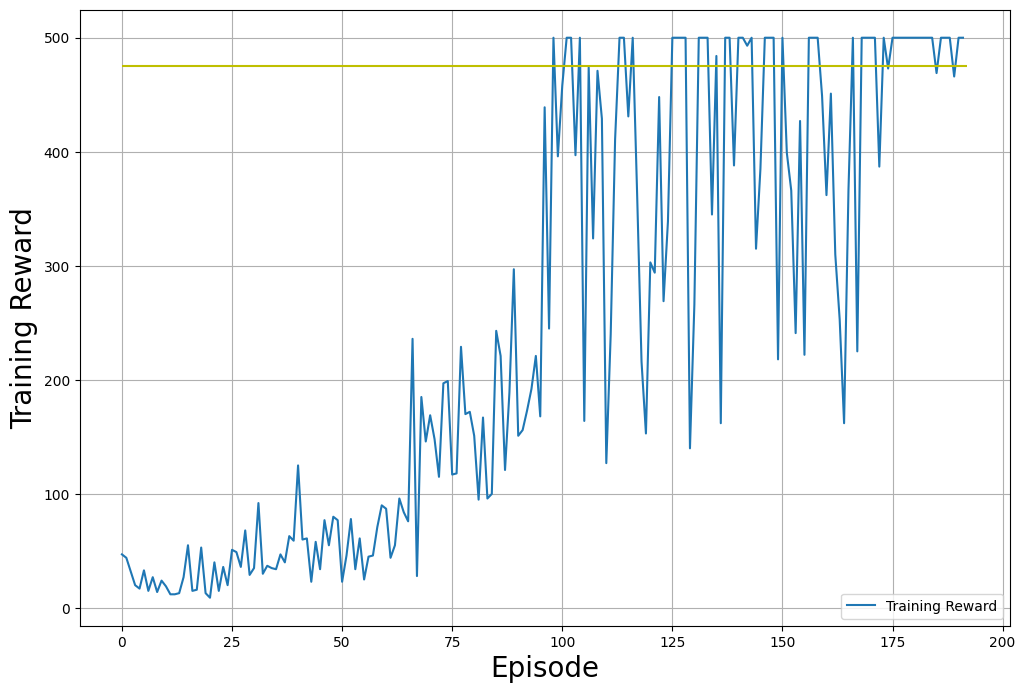

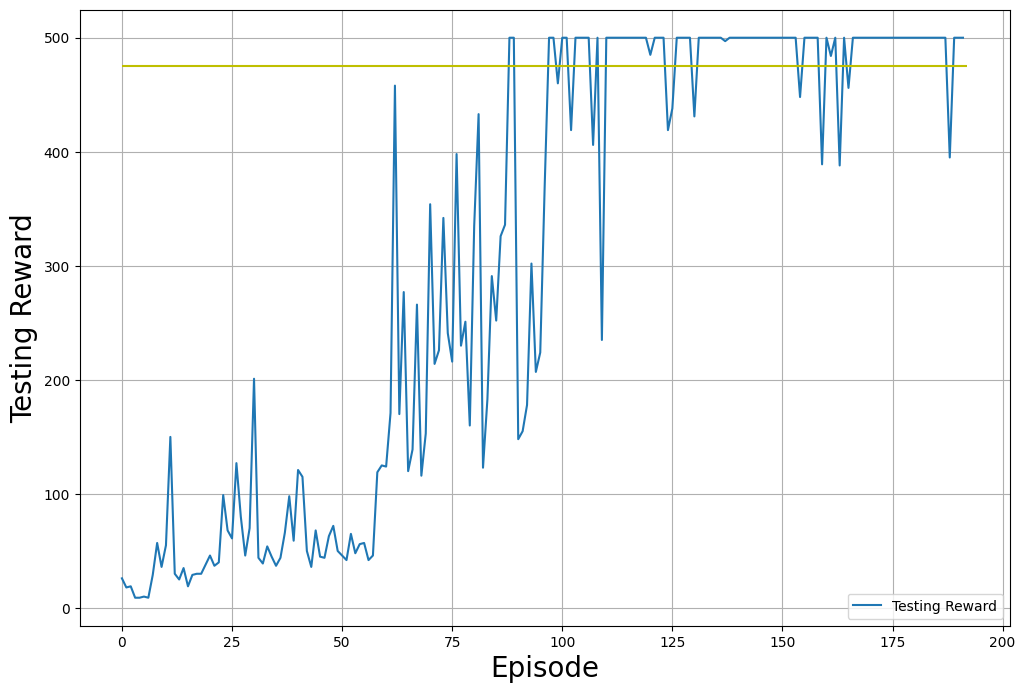

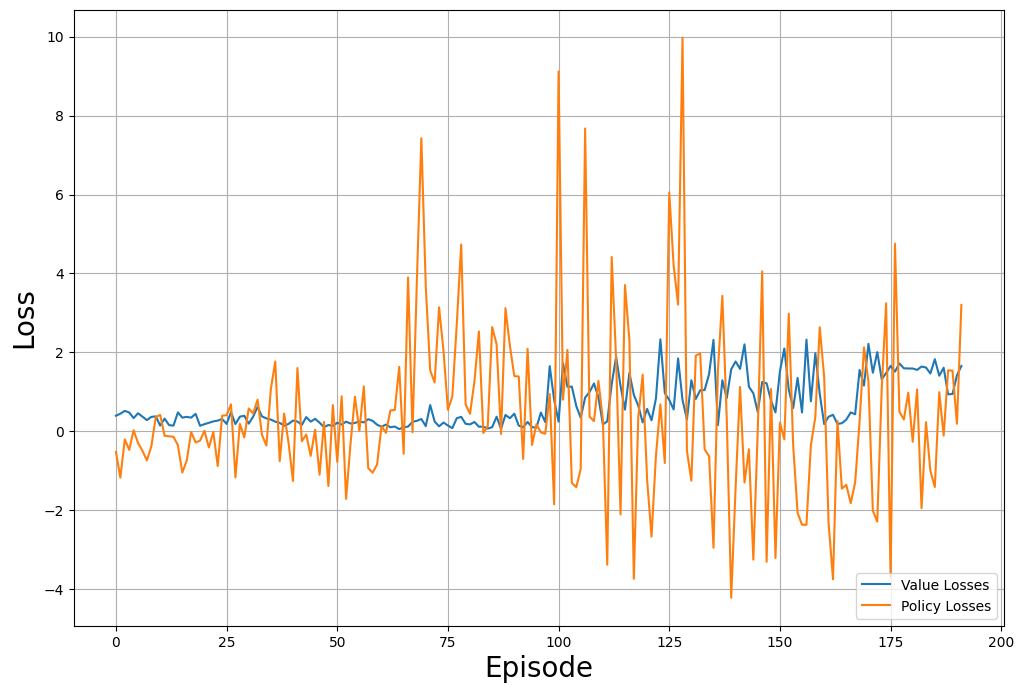

In [29]:
run_ppo()